In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
# imports

from tensorflow.keras.applications import vgg16,vgg19,DenseNet201
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import cv2
import numpy as np
import pickle
import json
from tqdm import tqdm

In [73]:
import tensorflow as tf
import keras
print(keras.__version__)
print(tf.__version__)

2.5.0
2.5.0


In [74]:
# parameters setup

imgs_path = "/content/drive/MyDrive/BLKBOX/All_Image/"
target_path = "/content/drive/MyDrive/BLKBOX/test/"
imgs_model_width, imgs_model_height = 224, 224

nb_closest_images = 10 # number of most similar images to retrieve

In [75]:
# load the model
#vgg_model = vgg19.VGG19(weights='imagenet')
dense_model = DenseNet201(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=dense_model.input, outputs=dense_model.get_layer("avg_pool").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [76]:
files = [imgs_path + x for x in os.listdir(imgs_path) if ".png" in x]
files = np.random.choice(files, 50)
print("number of images:",len(files))
files = list(set(files))
files

number of images: 50


['/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-a73ed2328d559d5654b956a4e8f8b6b8:6519.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_300588617701811-673119063631798:7977.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_2373611469605665-709590876414734:8158.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_1195641163801544-9ef0b019c2aac9b15ffc73978470ec6d:4226.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_2747337658924217-211744187001864:7634.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_125428025564921-523427001657485:1464.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_2150947825213215-93c18167817b7f923921b9d95d083f4e:1260.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_303483037623868-223365585905186:7125.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_1358560517596540-4c23baac092d3f1c0383b5b13748a7ba:4329.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_300588617701811-138590324535421:7759.png',
 '/content/drive/MyDrive/BLKBOX/All_I

In [77]:
files1 = [target_path + x for x in os.listdir(target_path) if "png" in x]
files1 = np.random.choice(files1, 3)
print("number of images:",len(files1))
files1 = list(files1)
files1

number of images: 3


['/content/drive/MyDrive/BLKBOX/test/act_439286853957566-373422960460627:34.png',
 '/content/drive/MyDrive/BLKBOX/test/act_439286853957566-2808ff4633e56ed43a7d2eb65f06cbdd:10.png',
 '/content/drive/MyDrive/BLKBOX/test/act_439286853957566-468426427812844:13.png']

In [78]:
# load all the images and prepare them for feeding into the CNN
def feat_extract(files):
    files2 = []
    counter = 0
    importedImages = []

    for f in tqdm(files,desc="Image to array conversion on:"):
        filename = f
        try:
          original = load_img(filename,target_size=(imgs_model_width, imgs_model_height))
          files2.append(filename)
          numpy_image = img_to_array(original)
          image_batch = np.expand_dims(numpy_image, axis=0)
          importedImages.append(image_batch)
          counter += 1
          print(counter)
          pass
        except:
          continue  
    images = np.vstack(importedImages)

    processed_imgs = preprocess_input(images.copy())

    # extract the images features
    print("features extraction started!")
    imgs_features = feat_extractor.predict(processed_imgs)

    print("features successfully extracted!")
    print(img_features.shape)
    return imgs_features, files2


In [79]:
imgs_features_train, files_train = feat_extract(files)
imgs_features_test, files_test = feat_extract(files1)

Image to array conversion on::   0%|          | 0/50 [00:00<?, ?it/s]

1


Image to array conversion on::   4%|▍         | 2/50 [00:00<00:09,  5.16it/s]

2


Image to array conversion on::   6%|▌         | 3/50 [00:00<00:11,  4.21it/s]

3


Image to array conversion on::   8%|▊         | 4/50 [00:01<00:13,  3.48it/s]

4


Image to array conversion on::  10%|█         | 5/50 [00:01<00:13,  3.25it/s]

5


Image to array conversion on::  12%|█▏        | 6/50 [00:01<00:13,  3.25it/s]

6


Image to array conversion on::  14%|█▍        | 7/50 [00:02<00:13,  3.29it/s]

7


Image to array conversion on::  16%|█▌        | 8/50 [00:02<00:15,  2.71it/s]

8


Image to array conversion on::  18%|█▊        | 9/50 [00:02<00:13,  2.94it/s]

9


Image to array conversion on::  20%|██        | 10/50 [00:03<00:13,  3.05it/s]

10


Image to array conversion on::  22%|██▏       | 11/50 [00:03<00:13,  2.90it/s]

11


Image to array conversion on::  24%|██▍       | 12/50 [00:03<00:13,  2.77it/s]

12


Image to array conversion on::  26%|██▌       | 13/50 [00:04<00:12,  2.87it/s]

13


Image to array conversion on::  28%|██▊       | 14/50 [00:04<00:12,  2.86it/s]

14


Image to array conversion on::  30%|███       | 15/50 [00:04<00:11,  3.16it/s]

15


Image to array conversion on::  32%|███▏      | 16/50 [00:05<00:10,  3.30it/s]

16


Image to array conversion on::  34%|███▍      | 17/50 [00:05<00:09,  3.46it/s]

17


Image to array conversion on::  36%|███▌      | 18/50 [00:05<00:09,  3.43it/s]

18


Image to array conversion on::  38%|███▊      | 19/50 [00:06<00:09,  3.31it/s]

19


Image to array conversion on::  40%|████      | 20/50 [00:06<00:09,  3.09it/s]

20


Image to array conversion on::  42%|████▏     | 21/50 [00:06<00:09,  3.00it/s]

21


Image to array conversion on::  44%|████▍     | 22/50 [00:07<00:09,  3.07it/s]

22


Image to array conversion on::  46%|████▌     | 23/50 [00:07<00:09,  2.85it/s]

23


Image to array conversion on::  48%|████▊     | 24/50 [00:07<00:09,  2.68it/s]

24


Image to array conversion on::  50%|█████     | 25/50 [00:08<00:09,  2.61it/s]

25


Image to array conversion on::  52%|█████▏    | 26/50 [00:08<00:09,  2.61it/s]

26


Image to array conversion on::  54%|█████▍    | 27/50 [00:09<00:08,  2.74it/s]

27


Image to array conversion on::  56%|█████▌    | 28/50 [00:09<00:07,  2.91it/s]

28


Image to array conversion on::  58%|█████▊    | 29/50 [00:09<00:07,  2.80it/s]

29


Image to array conversion on::  60%|██████    | 30/50 [00:10<00:07,  2.83it/s]

30


Image to array conversion on::  62%|██████▏   | 31/50 [00:10<00:06,  2.97it/s]

31


Image to array conversion on::  64%|██████▍   | 32/50 [00:10<00:06,  2.72it/s]

32


Image to array conversion on::  66%|██████▌   | 33/50 [00:11<00:05,  2.97it/s]

33


Image to array conversion on::  68%|██████▊   | 34/50 [00:11<00:05,  2.77it/s]

34


Image to array conversion on::  70%|███████   | 35/50 [00:11<00:05,  2.74it/s]

35


Image to array conversion on::  72%|███████▏  | 36/50 [00:12<00:04,  2.84it/s]

36


Image to array conversion on::  74%|███████▍  | 37/50 [00:12<00:04,  2.91it/s]

37


Image to array conversion on::  76%|███████▌  | 38/50 [00:12<00:04,  2.99it/s]

38


Image to array conversion on::  78%|███████▊  | 39/50 [00:13<00:03,  2.79it/s]

39


Image to array conversion on::  80%|████████  | 40/50 [00:13<00:03,  2.94it/s]

40


Image to array conversion on::  82%|████████▏ | 41/50 [00:13<00:02,  3.16it/s]

41


Image to array conversion on::  84%|████████▍ | 42/50 [00:14<00:02,  3.29it/s]

42


Image to array conversion on::  86%|████████▌ | 43/50 [00:14<00:02,  3.26it/s]

43


Image to array conversion on::  88%|████████▊ | 44/50 [00:14<00:01,  3.40it/s]

44


Image to array conversion on::  90%|█████████ | 45/50 [00:15<00:01,  3.00it/s]

45


Image to array conversion on::  92%|█████████▏| 46/50 [00:15<00:01,  3.03it/s]

46


Image to array conversion on::  94%|█████████▍| 47/50 [00:15<00:00,  3.22it/s]

47


Image to array conversion on::  96%|█████████▌| 48/50 [00:16<00:00,  2.96it/s]

48


Image to array conversion on::  98%|█████████▊| 49/50 [00:16<00:00,  2.97it/s]

49


Image to array conversion on:: 100%|██████████| 50/50 [00:16<00:00,  3.00it/s]

50
features extraction started!



Image to array conversion on::   0%|          | 0/3 [00:00<?, ?it/s]

features successfully extracted!
(50, 1920)


Image to array conversion on::  33%|███▎      | 1/3 [00:00<00:00,  3.06it/s]

1


Image to array conversion on::  67%|██████▋   | 2/3 [00:00<00:00,  3.15it/s]

2


Image to array conversion on:: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

3
features extraction started!
features successfully extracted!
(50, 1920)


In [80]:
np.save("/content/drive/MyDrive/BLKBOX/training_data_storage/Densenettest", imgs_features_train)

In [81]:
img_features_train = np.load("/content/drive/MyDrive/BLKBOX/training_data_storage/Densenettest.npy")

In [83]:
print(img_features_train.shape)
print(len(files_train))
print(imgs_features_test.shape)
print(len(files_test))

(50, 1920)
50
(3, 1920)
3


In [84]:
with open("/content/drive/MyDrive/BLKBOX/training_data_storage/Densenettest.txt","wb") as fp:
  pickle.dump(files_train, fp)

In [85]:
with open("/content/drive/MyDrive/BLKBOX/training_data_storage/Densenettest.txt","rb") as fp:
  files_train = pickle.load(fp)

In [86]:
arr = np.concatenate((imgs_features_train, imgs_features_test), axis=0)
arr.shape

(53, 1920)

In [87]:
files_all = files_train + files_test
files_all

['/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-a73ed2328d559d5654b956a4e8f8b6b8:6519.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_300588617701811-673119063631798:7977.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_2373611469605665-709590876414734:8158.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_1195641163801544-9ef0b019c2aac9b15ffc73978470ec6d:4226.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_2747337658924217-211744187001864:7634.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_125428025564921-523427001657485:1464.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_2150947825213215-93c18167817b7f923921b9d95d083f4e:1260.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_303483037623868-223365585905186:7125.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_1358560517596540-4c23baac092d3f1c0383b5b13748a7ba:4329.png',
 '/content/drive/MyDrive/BLKBOX/All_Image/act_300588617701811-138590324535421:7759.png',
 '/content/drive/MyDrive/BLKBOX/All_I

In [88]:
len(files_all)

53

In [89]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(arr)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files_all, index=files_all)
cos_similarities_df.head()

,/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-a73ed2328d559d5654b956a4e8f8b6b8:6519.png,/content/drive/MyDrive/BLKBOX/All_Image/act_300588617701811-673119063631798:7977.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2373611469605665-709590876414734:8158.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1195641163801544-9ef0b019c2aac9b15ffc73978470ec6d:4226.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2747337658924217-211744187001864:7634.png,/content/drive/MyDrive/BLKBOX/All_Image/act_125428025564921-523427001657485:1464.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2150947825213215-93c18167817b7f923921b9d95d083f4e:1260.png,/content/drive/MyDrive/BLKBOX/All_Image/act_303483037623868-223365585905186:7125.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1358560517596540-4c23baac092d3f1c0383b5b13748a7ba:4329.png,/content/drive/MyDrive/BLKBOX/All_Image/act_300588617701811-138590324535421:7759.png,/content/drive/MyDrive/BLKBOX/All_Image/act_300588617701811-858839531348740:8697.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1381417171977541-133628524956603:2991.png,/content/drive/MyDrive/BLKBOX/All_Image/act_748215912282143-f3f9fcfb2c9b7d33d4eeb81e7b620507:1004.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2150947825213215-2672023546401564:1036.png,/content/drive/MyDrive/BLKBOX/All_Image/act_530803134133407-2fd743b7791f9463fe60114c385a2141:3607.png,/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-278894e24b025222bcdf56a070103e9d:6677.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1381417171977541-72a2363d72b8c2e9af2571e6ab561615:3059.png,/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-685d519afc831c0d39154b0ed15de344:6063.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1418187388354857-544959759490092:4953.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2150947825213215-94dc8ba2c60205bb5997bb27416f87f6:2139.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2739071609447571-691117874770718:743.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1381417171977541-1523413467852192:3516.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2910534345682289-a353fe0a82c9efc7049e3b23889aa1d5:5898.png,/content/drive/MyDrive/BLKBOX/All_Image/act_393145255464655-697657334443857:7450.png,/content/drive/MyDrive/BLKBOX/All_Image/act_216584173102613-2612805228963008:4444.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2991319124266485-a4112a9a68b3bdc196d8df173bb9bd7c:5314.png,/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-1302966873393051:5448.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2991319124266485-1047702002325000:1124.png,/content/drive/MyDrive/BLKBOX/All_Image/act_530803134133407-1752496504889911:2068.png,/content/drive/MyDrive/BLKBOX/All_Image/act_380610706505821-754243711840178:8074.png,/content/drive/MyDrive/BLKBOX/All_Image/act_380610706505821-440110990727736:8075.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1358560517596540-447280976477265:2959.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1363272777046237-577701399655237:1205.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1195641163801544-187626056452052:1806.png,/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-6ec597fd238525180649eb1c4169ece2:6571.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2739071609447571-156143862488054:10.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1195641163801544-cf48b070affd4a738c35c0f9210c116a:5772.png,/content/drive/MyDrive/BLKBOX/All_Image/act_258424862030158-177622434215925:8884.png,/content/drive/MyDrive/BLKBOX/All_Image/act_2747337658924217-2af36e5beee93e96867a13ce11092ed5:7543.png,/content/drive/MyDrive/BLKBOX/All_Image/act_300588617701811-304730054062369:8445.png,/content/drive/MyDrive/BLKBOX/All_Image/act_1418187388354857-7dedb424e308030d8106b5ec7ef613fa:5210.png,/content/drive/MyDrive/BLKBOX/All_Image/act_726697918112306-940850073077457:7509.png,/content/drive/MyDrive/BLKBOX/All_Image/act_530803134133407-3292407470788894:3159.png,/content/drive/MyDrive/BLKBOX/All_Image/act_13

In [90]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_adds(given_img):

    print("*********************************")
    print("Original Add Image:")
    print("*********************************")
    print(given_img)
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("Most Similar Add Image Recommended:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        print(closest_imgs[i])
        plt.imshow(original)
        plt.show()
        print("Cosine Similarity Score: ",closest_imgs_scores[i])
        print('---------------------------------------------------------------------')

*********************************
Original Add Image:
*********************************
/content/drive/MyDrive/BLKBOX/test/act_439286853957566-2808ff4633e56ed43a7d2eb65f06cbdd:10.png


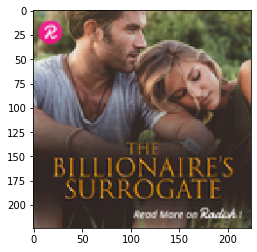

-----------------------------------------------------------------------
Most Similar Add Image Recommended:
/content/drive/MyDrive/BLKBOX/All_Image/act_1381417171977541-72a2363d72b8c2e9af2571e6ab561615:3059.png


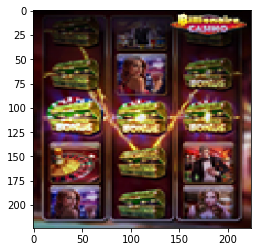

Cosine Similarity Score:  0.92750454
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/All_Image/act_2991319124266485-1047702002325000:1124.png


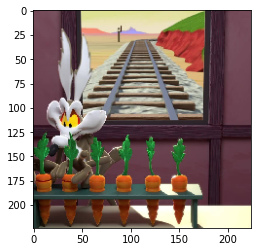

Cosine Similarity Score:  0.91769695
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-3566801ad73c84af09e17ac4ac90d4b0:6184.png


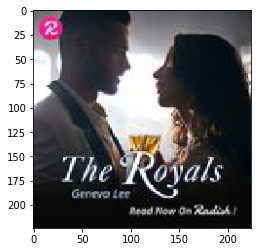

Cosine Similarity Score:  0.90439475
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/test/act_439286853957566-373422960460627:34.png


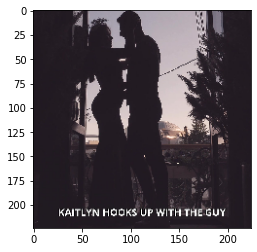

Cosine Similarity Score:  0.89961743
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/All_Image/act_2739071609447571-156143862488054:10.png


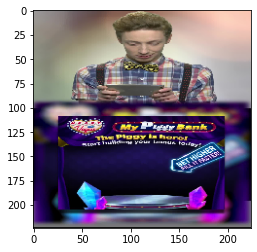

Cosine Similarity Score:  0.89488375
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/All_Image/act_216584173102613-2612805228963008:4444.png


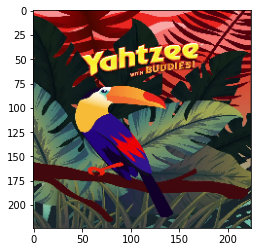

Cosine Similarity Score:  0.88654697
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-278894e24b025222bcdf56a070103e9d:6677.png


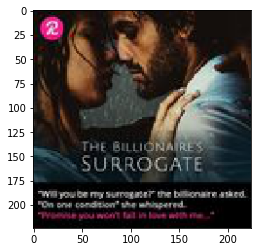

Cosine Similarity Score:  0.87599033
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/All_Image/act_1195641163801544-cf48b070affd4a738c35c0f9210c116a:5772.png


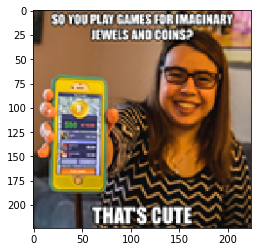

Cosine Similarity Score:  0.8752378
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/All_Image/act_1363272777046237-577701399655237:1205.png


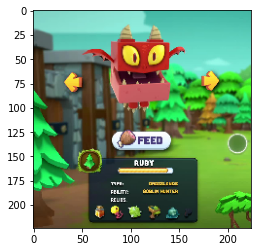

Cosine Similarity Score:  0.8737102
---------------------------------------------------------------------
/content/drive/MyDrive/BLKBOX/All_Image/act_318549416033487-685d519afc831c0d39154b0ed15de344:6063.png


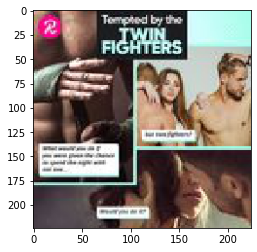

Cosine Similarity Score:  0.872704
---------------------------------------------------------------------


In [91]:
retrieve_most_similar_adds(files_all[len(files_all)-2])